# Maximum Likelihood on $t_{\rm dur}$

## Following: https://www.jstor.org/stable/pdf/25662336.pdf

## Especially for the discrete case

In [229]:
# imports
import numpy as np
from scipy.interpolate import interp1d
from scipy import special

from matplotlib import pyplot as plt

import seaborn as sns

from mhw_analysis.systems import io as mhw_sys_io

# Load up MHWS

In [3]:
mhw_sys = mhw_sys_io.load_systems(mhw_sys_file=None, vary=True)

Loading systems from /data/Projects/Oceanography/MHW/db/MHW_systems_vary.csv
Done


In [7]:
mhw_sys['duration'] = mhw_sys.zboxmax - mhw_sys.zboxmin + 1 # days

In [16]:
N_MHWS = len(mhw_sys)

# Histogram

In [8]:
bins = np.linspace(0.3, 4.0, 32)
if np.log10(np.max(mhw_sys.duration.values)+1) > bins[-1]:
    bins[-1] = np.log10(np.max(mhw_sys.duration.values)+1)

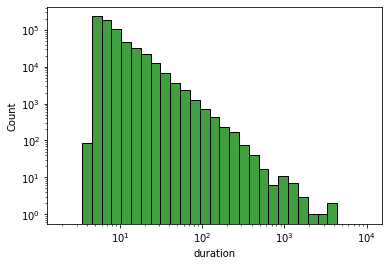

In [10]:
ax = sns.histplot(mhw_sys, x='duration', bins=bins, log_scale=True, color='g')
ax.set_yscale('log')

# Grid

In [11]:
pivot = 10. # days

In [141]:
alpha = np.linspace(-4, -2.01, 100)
Phi_0 = 10**np.linspace(3., 6., 100)

In [142]:
alpha_grid = np.outer(alpha, np.ones_like(Phi_0))
Phi_grid = np.outer(np.ones_like(alpha), Phi_0)

In [144]:
tmin, tmax = mhw_sys.duration.min(), mhw_sys.duration.max()
tmin, tmax

(4, 4063)

In [204]:
# Hard code
tmin=4.5

In [205]:
gd_sys = mhw_sys.duration >= tmin

In [206]:
tmin

4.5

## Normalization

## $- \int_{\rm min}^{\rm max} \Phi(x) dx$

In [207]:
norm = pivot * Phi_grid * ((tmax/pivot)**(alpha_grid+1) - (tmin/pivot)**(alpha_grid+1)) / (1+alpha_grid)

## Const term

## $N_{\rm sys} \ln \Phi_0$

In [208]:
const = np.sum(gd_sys) * np.log(Phi_grid)

## Inner term

## $\alpha \Sigma_i \ln (t_i/pivot)$

In [209]:
inner = alpha_grid * np.sum(np.log(mhw_sys[gd_sys].duration.values/pivot))

# Likelihood

In [210]:
logL = -1*norm + const + inner

In [211]:
maxL = logL.max()
maxL

6649709.896339128

In [212]:
logL.min()

-26685313.378301516

In [213]:
iamx, iPmx = np.unravel_index(logL.argmax(), logL.shape)
iamx, iPmx

(52, 47)

In [215]:
best_alpha = alpha[iamx]
best_Phi = Phi_0[iamx]
best_alpha, best_Phi

(-2.9547474747474745, 37649.35806792471)

## Some polishing

In [216]:
norm_img = logL-logL.max()

In [217]:
flat_img = norm_img.flatten()
# Sort
srt = np.argsort(flat_img)
norm_lnL = flat_img[srt]
# Sum
cumulsum = np.cumsum(np.exp(np.maximum(norm_lnL,-15.)))
cumul = cumulsum/cumulsum[-1]
# Interpolation (smoothing a bit)
fsum = interp1d(cumul, norm_lnL)
contours = [0.99,0.95,0.68]
clevels=[]
clrs = ('r','g','k')
for contour in contours:
    clevels.append(fsum(1.-contour))
# Add the zero contour
clevels.append(0.)

In [218]:
clevels

[array(-42.1375703), array(-40.43504221), array(-28.94297758), 0.0]

## Plot

In [219]:
X,Y = np.meshgrid(np.log10(Phi_0), alpha)

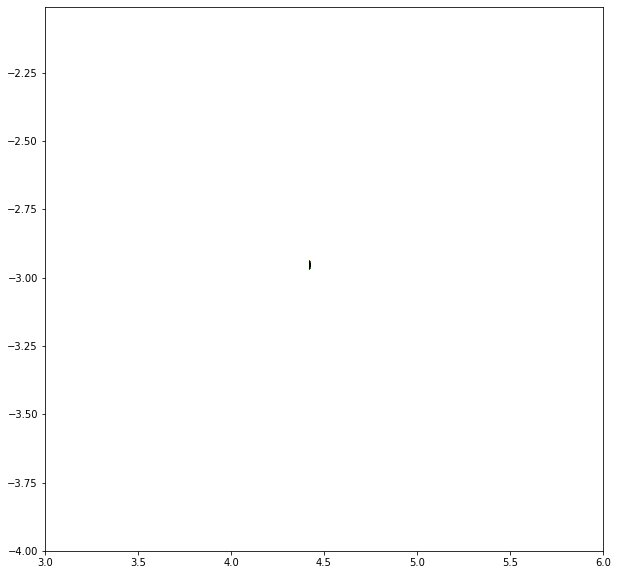

In [220]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#img = ax.imshow(logL, origin='lower', vmin=0.)
               #extent=(alpha.min(), alpha.max(),
               #       Phi_0.min(), Phi_0.max()),
               #aspect='equal')
CS = ax.contourf(X, Y, norm_img, clevels,
                   colors=clrs,
                   origin='lower',
                   extend='neither')
#cb = plt.colorbar(img)
#
plt.show()

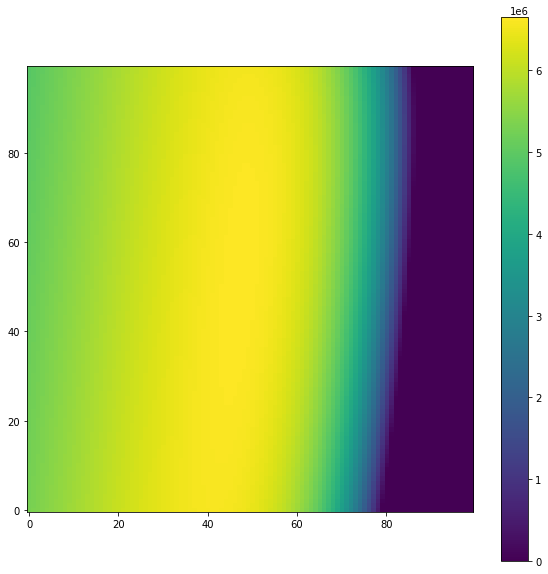

In [221]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#img = ax.imshow(-1*norm, origin='lower')#, vmin=0.)

img = ax.imshow(logL, origin='lower', vmin=0.)
               #extent=(alpha.min(), alpha.max(),
               #       Phi_0.min(), Phi_0.max()),
               #aspect='equal')
#CS = ax.contourf(X, Y, norm_img, clevels,
#                   colors=clrs,
#                   origin='lower',
#                   extend='neither')
cb = plt.colorbar(img)
#
plt.show()

## CDF

## Fit

In [222]:
tval = 10**np.linspace(np.log10(tmin), np.log10(tmax), 200)

In [223]:
#best_Phi, best_alpha = 3e4, -3.

In [224]:
Nsys_cum = pivot * best_Phi *  ((tmax/pivot)**(best_alpha+1) - (
    tval/pivot)**(best_alpha+1)) / (1+best_alpha)

In [225]:
best_alpha, best_Phi

(-2.9547474747474745, 37649.35806792471)

## Data

In [226]:
Nsys_data = []
for t in tval:
    gd = mhw_sys.duration >= t
    Nsys_data.append(np.sum(gd))

## Plot

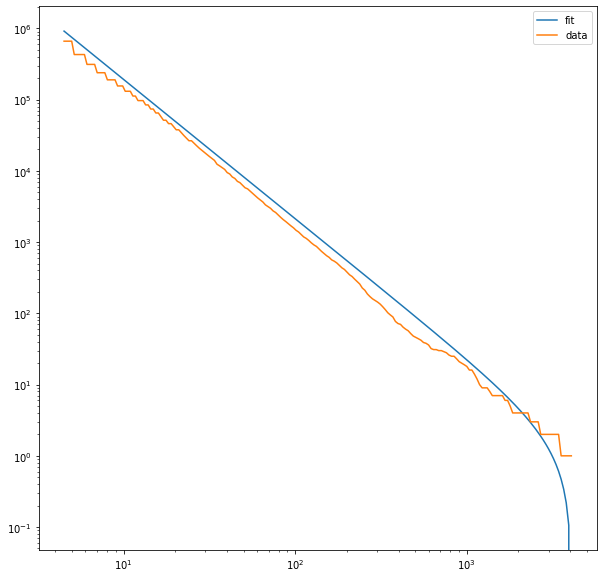

In [227]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#
ax.plot(tval, Nsys_cum, label='fit')
ax.plot(tval, Nsys_data, label='data')
#
ax.set_xscale('log')
ax.set_yscale('log')
#
ax.legend()
#
plt.show()

## Real CDF

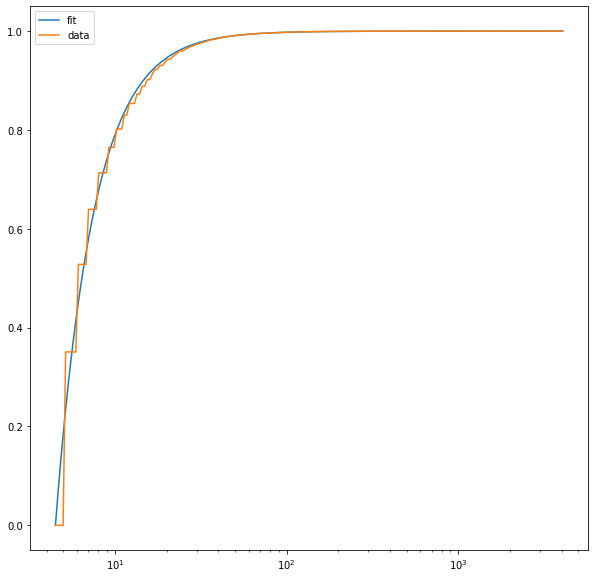

In [228]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#
ax.plot(tval, 1.-Nsys_cum/Nsys_cum[0], label='fit')
ax.plot(tval, 1-Nsys_data/Nsys_data[0], label='data')
#
ax.set_xscale('log')
#ax.set_yscale('log')
#
#ax.set_ylim(0.01, 1.)
ax.legend()
#
plt.show()

----

# Power-law exponent only

In [243]:
alpha = np.linspace(-4, -2.01, 1000)

In [244]:
zeta = special.zeta(-1*alpha, 5)

In [245]:
logL_1 = -np.sum(gd_sys) * np.log(zeta) + alpha*np.sum(np.log(mhw_sys[gd_sys].duration.values))

In [247]:
iamx = np.argmax(logL_1)
best_alpha = alpha[iamx]
best_alpha

-2.9661561561561562

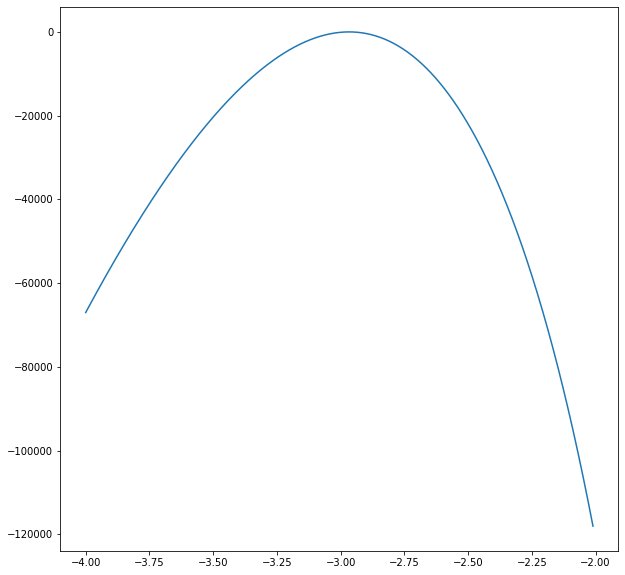

In [246]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#
ax.plot(alpha, logL_1-logL_1.max(), label='fit')
#ax.plot(tval, 1-Nsys_data/Nsys_data[0], label='data')
#
#ax.set_xscale('log')
#ax.set_yscale('log')
#
#ax.set_ylim(0.01, 1.)
#ax.legend()
#
plt.show()

In [236]:
approx = 1 + np.sum(gd_sys)/(np.sum(np.log(mhw_sys[gd_sys].duration/(5-0.5))))

In [237]:
approx

2.929134829038893

## Constant

In [250]:
C = 1./special.zeta(-1*best_alpha, 5)
C

38.28570348993087

## CDF

In [251]:
tval = np.arange(5, int(tmax)+1)

In [259]:
Pt_fit = C*tval**(best_alpha)
CDF_fit = np.cumsum(Pt_fit)/np.sum(Pt_fit)
np.sum(Pt_fit)

0.9999984377262108

In [260]:
Pt_fit[0]

0.32343160076303584

In [274]:
xdata, counts = np.unique(mhw_sys[gd_sys].duration.values, return_counts=True)

In [275]:
CDF_data = np.cumsum(counts) / np.sum(counts)

In [257]:
Nsys_data = []
for t in tval:
    gd = mhw_sys.duration == t
    Nsys_data.append(np.sum(gd))
# 
Nsys_data = np.array(Nsys_data)
CDF_data = np.cumsum(Nsys_data)/np.sum(Nsys_data)

In [262]:
np.sum(mhw_sys.duration == 5) / np.sum(gd_sys)

0.3507936388132024

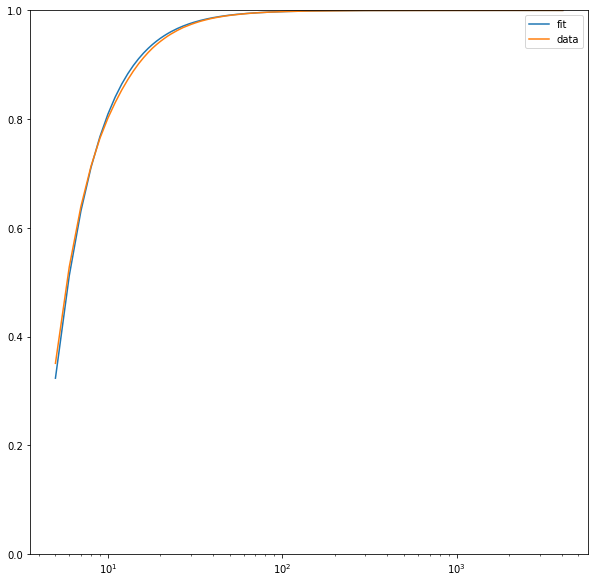

In [277]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
#
ax.plot(tval, CDF_fit, label='fit')
ax.plot(xdata, CDF_data, label='data')
#
ax.set_xscale('log')
#ax.set_yscale('log')
#
ax.set_ylim(0.0, 1.)
ax.legend()
#
plt.show()

## Max Area

In [267]:
xval = mhw_sys.max_area.values
xmin = xval.min()
xmin

1

In [268]:
alpha2 = np.linspace(-2, -1.01, 1000)

In [269]:
zeta = special.zeta(-1*alpha2, xmin)

In [270]:
logL_maxA = -xval.size * np.log(zeta) + alpha2*np.sum(np.log(xval))

In [271]:
imaxA = np.argmax(logL_maxA)

In [272]:
alpha2[imaxA]

-1.448018018018018